<a href="https://colab.research.google.com/github/Yevheniia-Ilchenko/ML_DS_tasks/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd
df = pd.read_csv("train.csv", index_col=False)
df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [2]:
df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [3]:
df_cleaned = df.dropna()
df_cleaned.isnull().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [4]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [5]:
print(df_cleaned.sentiment.value_counts())
print("\n")
print(df["sentiment"].value_counts(normalize=True).round(3) * 100)

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


sentiment
neutral     40.5
positive    31.2
negative    28.3
Name: proportion, dtype: float64


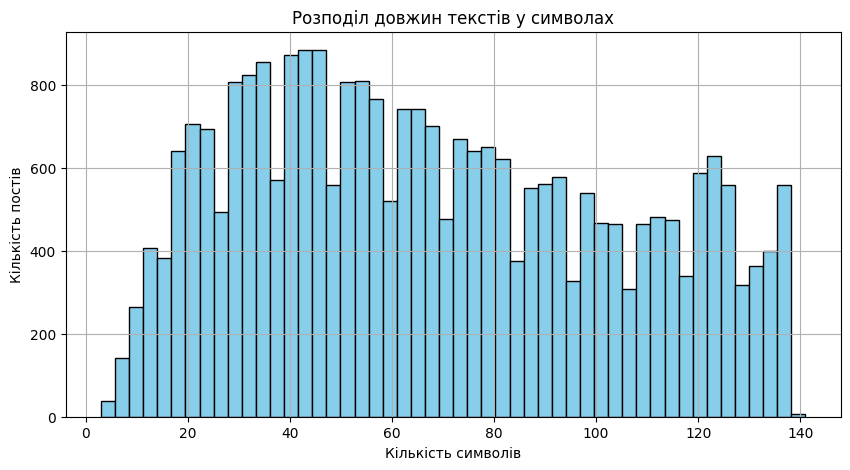

In [6]:
import matplotlib.pyplot as plt

df["text_length"] = df["text"].astype(str).apply(len)

plt.figure(figsize=(10, 5))
plt.hist(df["text_length"], bins=50, color='skyblue', edgecolor='black')
plt.title("Розподіл довжин текстів у символах")
plt.xlabel("Кількість символів")
plt.ylabel("Кількість постів")
plt.grid(True)
plt.show()

In [7]:
print("Середня довжина:", df["text_length"].mean())
print("Медіанна довжина:", df["text_length"].median())
print("Максимум:", df["text_length"].max())

Середня довжина: 68.32764455441942
Медіанна довжина: 64.0
Максимум: 141


Середня та типова довжина постів — від 30 до 60 символів

постів довжиною до 100 символів — більшість

Тексти однаково часто мають і середню, і дещо більшу довжину — що робить модель обробки тексту збалансованою

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [8]:
!pip install --upgrade nltk

In [9]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
texts = df_cleaned['text']
stop_words = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

In [13]:
cleaned_texts = texts.apply(preprocess_text)
vectorizer = CountVectorizer(max_features=3000)
X_bow = vectorizer.fit_transform(cleaned_texts)

In [14]:
print(X_bow.shape)
print(vectorizer.get_feature_names_out()[:20])

(27480, 3000)
['aah' 'abandon' 'abil' 'abit' 'abl' 'absolut' 'abt' 'ac' 'academi'
 'accept' 'access' 'accid' 'accident' 'accomplish' 'accord' 'account'
 'ace' 'ach' 'achiev' 'ack']


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [17]:
from sklearn.preprocessing import LabelEncoder
df_cleaned = df_cleaned.copy()
encoder = LabelEncoder()
df_cleaned[ 'sentiment_encoded'] = encoder.fit_transform(df_cleaned['sentiment'])

label_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Мапа міток:", label_map)

Мапа міток: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


In [18]:
from sklearn.model_selection import train_test_split
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, df_cleaned.sentiment_encoded,
                                                                        test_size=0.3, random_state=42)

In [19]:
from sklearn.linear_model import LogisticRegression
MAX_ITER = 1000
model = LogisticRegression(max_iter=MAX_ITER, solver='sag')

In [20]:
%%time
model.fit(X_train_bow, y_train)

CPU times: user 985 ms, sys: 1.55 ms, total: 986 ms
Wall time: 1.03 s


LogisticRegression(max_iter=1000, solver='sag')

In [21]:
train_preds = model.predict(X_train_bow)

In [22]:
pd.Series(train_preds).value_counts()


,count
1,8660
2,5766
0,4810


In [23]:
pd.Series(y_train).value_counts()

,count
sentiment_encoded,
1,7774
2,6037
0,5425


In [24]:
y_train.shape

(19236,)

In [25]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print(accuracy_score(y_train, train_preds))
print(f1_score(y_train, train_preds, average='macro'))


0.7922645040548971
0.7927719740721999


In [26]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      5425
           1       0.74      0.83      0.78      7774
           2       0.84      0.80      0.82      6037

    accuracy                           0.79     19236
   macro avg       0.80      0.79      0.79     19236
weighted avg       0.80      0.79      0.79     19236



Цей звіт класифікації свідчить про досить хорошу якість моделі, але з кількома моментами для покращення.

Клас 1 (neutral) має нижчу precision (0.74), але хорошу recall (0.83) — отже, модель часто відносить до цього класу навіть сумнівні випадки.

Клас 0 (negative) має нижчий recall (0.73), тобто не всі негативні пости знаходяться.

Клас 2 (positive) класифікується найкраще — F1 = 0.82.


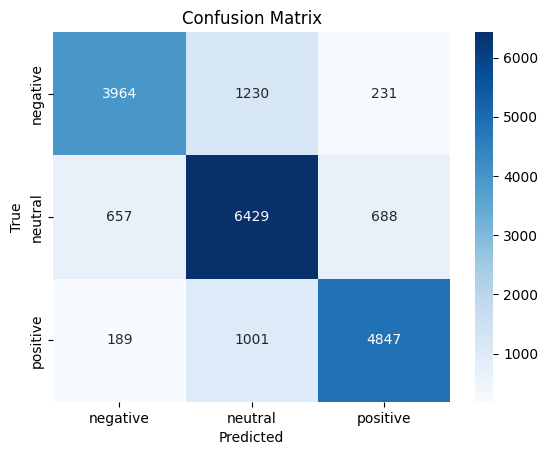

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, train_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Висновки:
"Neutral" — найкраще передбачуваний клас (6429 вгадано правильно).

"Negative" — найчастіше плутається з neutral, що типово для задач сентимент-аналізу.

"Positive" — також часто класифікується як neutral

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [28]:
feature_importance = pd.Series(model.coef_[0], index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance

,imp
sad,2.530223
suck,2.438449
bore,2.259096
sorri,2.227408
hate,2.124948
...,...
thank,-1.917793
glad,-1.990913
cute,-2.011437
love,-2.019627


Помітно що деяки слова love, awesom, cute та інші можуть впливати в зворотньому напряміна вагу токсичних слів, і змінити результат в класифікації

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(cleaned_texts)
df_cleaned = df_cleaned.copy()
encoder = LabelEncoder()
df_cleaned[ 'sentiment_encoded'] = encoder.fit_transform(df_cleaned['sentiment'])

label_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df_cleaned.sentiment_encoded,
                                                                        test_size=0.3, random_state=42)
MAX_ITER = 1000
model = LogisticRegression(max_iter=MAX_ITER, solver='sag')
model.fit(X_train_tfidf, y_train)
train_preds = model.predict(X_train_tfidf)

In [31]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print(accuracy_score(y_train, train_preds))
print(f1_score(y_train, train_preds, average='macro'))

0.814462466209191
0.814967472263783


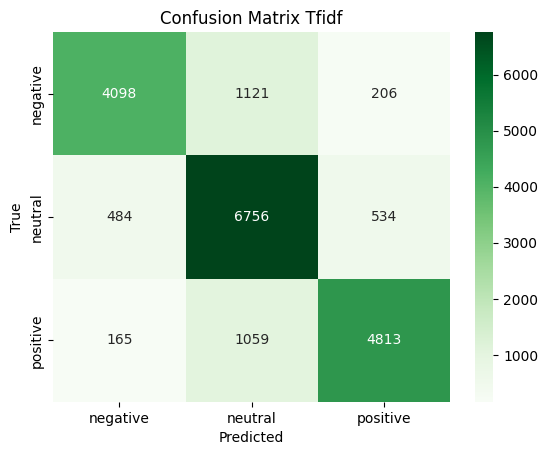

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, train_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Tfidf")
plt.show()

In [39]:
feature_importance = pd.Series(model.coef_[0], index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance

,imp
sad,5.354637
miss,5.270796
suck,4.513692
sorri,4.362585
hate,4.317199
...,...
great,-3.022467
hope,-3.286347
awesom,-3.409506
thank,-3.869705


Не бачу великої різниці в **feature_importance**, але кількість правильних передбачень (4098, 6756, 4813) зросла порівняно з першою матрицею — модель стала точнішою. Результат покращився **на 2% по f1**  тому схиляюся до вибору **Tfidf**


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [41]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

X_tfidf = vectorizer.fit_transform(cleaned_texts)
df_cleaned = df_cleaned.copy()
encoder = LabelEncoder()
df_cleaned[ 'sentiment_encoded'] = encoder.fit_transform(df_cleaned['sentiment'])

label_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df_cleaned.sentiment_encoded,
                                                                        test_size=0.3, random_state=42)
MAX_ITER = 1000
model_2 = LogisticRegression(max_iter=MAX_ITER, solver='sag')
model_2.fit(X_train_tfidf, y_train)
train_preds = model_2.predict(X_train_tfidf)

In [42]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print(accuracy_score(y_train, train_preds))
print(f1_score(y_train, train_preds, average='macro'))

0.9101684341859014
0.9106629996437219


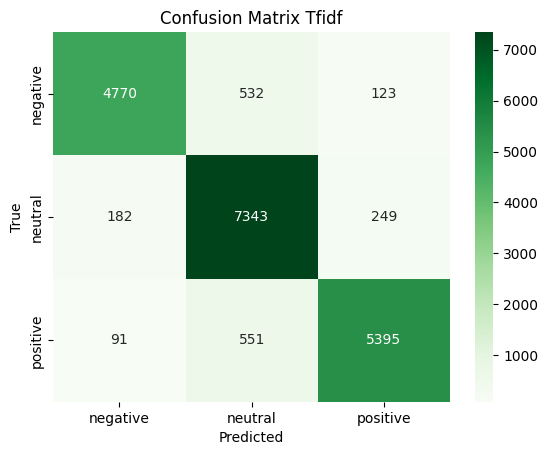

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, train_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Tfidf")
plt.show()

Додати н-грамні фічі (біграми, триграми)
Замість тільки окремих слів (n=1), додати біграми (n=2).

Це допоможе захоплювати короткі фрази типу "not good", "very bad", "really happy", які важливі для сенсу.

**І тепер оцінка виросла до 91%**

можна ще:

- Додати емоційні фічі або аналіз сентименту як окремі ознаки
- Знизити вагу слів, які однаково часто зустрічаються в усіх класах


І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model